In [1]:
# import functions
# version 2: did not use imputation. just ML directly 

# parameters:

import pandas as pd
import numpy as np
import codecs
import matplotlib.pyplot as plt
import random
import csv

import datetime
from dateutil.parser import parse
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from sklearn.preprocessing import StandardScaler                 #normalising features
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sknn import mlp

from scipy.optimize import minimize

import theano
import theano.tensor as T

%matplotlib inline

np.random.seed=10


ImportError: No module named fancyimpute

In [ ]:
import matplotlib.pyplot as plt

from py4j.java_gateway import JavaGateway

In [ ]:
%matplotlib inline

# set up connection

In [ ]:
gw = JavaGateway() # New gateway connection
bridge = gw.entry_point

# load netlogo model

In [ ]:
# Path to the model:
models_path = "D:/Work/PhD/Github/NetLogoModel/"
model_name = "PhD_InitialModelV3.nlogo"

In [ ]:
modelLocation = models_path + model_name

In [ ]:
modelLocation

In [ ]:
bridge.openModel(modelLocation)

# Run one iteration of the model, one command at a time:

In [ ]:
bridge.command("set grid-size 21")
bridge.command("set nb-people 1")
bridge.command("set Show_Names_Nodes? False")
bridge.command("set Show_Names_people? False")
bridge.command("set car-speed 1")
bridge.command("set mobiletowerdata? True")
bridge.command("set socialmedia_data? True")
bridge.command("set grids_covered_vector 10")
bridge.command("set avg_num_calls_perday 100")
bridge.command("set avg_call_duration_mins 2")

bridge.command("random-seed 0")
bridge.command("setup")
bridge.command("repeat 1440 [go]")

In [ ]:
bridge.command("repeat 144000 [go]")

# Have the model report results

In [ ]:
!head -n 15 ./agentdata.txt

In [ ]:
!head -n 15 ./mobiletowers.txt

In [9]:
# initiating the netlogo model
# and run it for the first 10 days
def model_init(ini_mins):
    bridge.command("set grid-size 21")
    bridge.command("set nb-people 1")
    bridge.command("set Show_Names_Nodes? False")
    bridge.command("set Show_Names_people? False")
    bridge.command("set car-speed 1")
    bridge.command("set mobiletowerdata? True")
    bridge.command("set socialmedia_data? True")
    bridge.command("set grids_covered_vector 5")
    bridge.command("set avg_num_calls_perday 10")
    bridge.command("set avg_call_duration_mins 2")
    bridge.command("random-seed 0")
    bridge.command("setup")
    bridge.command("repeat " + str(ini_mins) + " [go]")
    

In [10]:
def Schedule_Gen(CV, day_num):
    # generate population and schedules

    pop_num = range(1)
    type_num = 1    # type of the person being generated: 1: full time employment
    day_num = 100   # number of days to be simulated

    # assuming the following schedule sequence:
    mu_Wmorning = 450 #time to go out (7:30)
    sigma_Wmorning = mu_Wmorning*CV #standard deviation of morning trip
    mu_Wnoon = 210 #duration of morning work
    sigma_Wnoon = mu_Wnoon*CV #standard deviation of the duration of morning work
    mu_L = 60 # duration of lunch break
    sigma_L = mu_L*CV #standard deviation of the duration of lunch break
    mu_Wafnoon = 270 #duration of afternoon work
    sigma_Wafnoon = mu_Wafnoon*CV #standard deviation of the duration of morning work

    trip_Wmorning = [int(x) for x in np.random.normal(mu_Wmorning, sigma_Wmorning, day_num)] #generate start time based on normal distribution
    trip_Wnoon = [int(x) for x in np.random.normal(mu_Wnoon, sigma_Wnoon, day_num)] # work duration in the morning
    trip_Wafnoon = [int(x) for x in np.random.normal(mu_Wafnoon, sigma_Wafnoon, day_num)] #work duration in the afternoon
    trip_L = [int(x) for x in np.random.normal(mu_L, sigma_L, day_num)] #lunch break in the noon
    trip_Smorning = [int(x) for x in np.random.normal(mu_L, sigma_L, day_num)] #school trip in the morning
    trip_Safnoon = [int(x) for x in np.random.normal(mu_L, sigma_L, day_num)] #school trip in the afternoon

    z_home = 'home'#15 #zone number for home
    z_work = 'work'#25 #zone for work
    z_shop = 'shopping'#35 #zone number for shopping
    z_school = 'school'#45 #zone number for school

    for y in pop_num:
        demand_data = pd.DataFrame(None)
        demand_data['id'] = range(day_num*1440) 
        demand_data['day_id'] = [int(x/ 1440) for x in demand_data['id']]
        demand_data['minute_id'] = demand_data['id'] % 1440
        base = datetime.datetime.strptime('2015-01-01 00:00',  '%Y-%m-%d %H:%M')
        datetime_list = [base + datetime.timedelta(minutes=x) for x in range(0, day_num*1440)]
        dow = [datetime.datetime.isoweekday(x) for x in datetime_list]
        hr = [x.hour for x in datetime_list]
        minu = [x.minute for x in datetime_list]
        demand_data['datetime'] = [datetime.datetime.strftime(x, '%Y-%m-%d %H:%M') for x in datetime_list]
        demand_data['dow'] = dow
        demand_data['hour'] = hr
        demand_data['minute'] = minu
        demand_data['pid'] = y
        demand_data['type'] = type_num
        demand_data['zone'] = None
        cur_day = None
        uni_day = np.unique(demand_data['day_id'])
        for i in uni_day:
            cur_min = demand_data['minute_id'][i]
            Sch_drop_S = trip_Wmorning[i]
            Sch_drop_E = trip_Wmorning[i] + trip_Smorning[i]
            Wrk_Mor_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i]
            Shp_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i] + trip_L[i]
            Wrk_Aft_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i] + trip_L[i] + trip_Wafnoon[i]
            Sch_pik_E = trip_Wmorning[i] + trip_Smorning[i] + trip_Wnoon[i] + trip_L[i] + trip_Wafnoon[i] + trip_Safnoon[i]

            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][0:Sch_drop_S], 'zone', z_home)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Sch_drop_S:Sch_drop_E], 'zone', z_school)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Sch_drop_E:Wrk_Mor_E], 'zone', z_work)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Wrk_Mor_E:Shp_E], 'zone', z_shop)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Shp_E:Wrk_Aft_E], 'zone', z_work)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Wrk_Aft_E:Sch_pik_E], 'zone', z_school)
            demand_data.set_value(demand_data['id'][demand_data['day_id'] == i][Sch_pik_E:], 'zone', z_home)
        demand_data['zone'].to_csv('ActivitySchedule_' + str(y) + '.csv', header = False)
    

In [11]:
# import simuated data
# using function as the file can be closed automatically
def rawimport(path, columnname):
    agentdata = pd.read_csv(path, delimiter=' ', header=None, names=columnname)
    agentdata = agentdata.drop(labels="todrop", axis=1)
    return agentdata


In [12]:
# run NL model; 
def run_NL(mob_call):
    bridge.command(mob_call)


In [13]:
def data_input():
    path = './agentdata.txt'
    columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "zone", "status", "xcor", "ycor", "tid"]
    agentdata = rawimport(path, columnname)
    dt_stamp = [datetime.datetime.strptime(x,  '%Y-%m-%d %H:%M') for x in agentdata["acc_time"]]
    dow = [datetime.datetime.isoweekday(x) for x in dt_stamp]
    hr = [x.hour for x in dt_stamp]
    minu = [x.minute for x in dt_stamp]
    agentdata['dow'] = dow
    agentdata['hour'] = hr
    agentdata['minute'] = minu
    
    path = './mobiletowers.txt'
    columnname = ["todrop", "acc_time", "day", "acc_min", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
    mobiledata = rawimport(path, columnname)
    dt_stamp = [datetime.datetime.strptime(x,  '%Y-%m-%d %H:%M') for x in mobiledata["acc_time"]]
    dow = [datetime.datetime.isoweekday(x) for x in dt_stamp]
    hr = [x.hour for x in dt_stamp]
    minu = [x.minute for x in dt_stamp]
    mobiledata['dow'] = dow
    mobiledata['hour'] = hr
    mobiledata['minute'] = minu
    # leave the last n day(s) out for testing purpose

    # mobiledata_ML = mobiledata[mobiledata['day'] <= (mobiledata['day'].max() - last_n)]
    mobiledata_ML = mobiledata.drop('radius', axis = 1)
    mobiledata_ML.drop('acc_time', axis=1, inplace=True)
    mobiledata_ML.drop('acc_min', axis=1, inplace=True)
    mobiledata_ML.drop('tid', axis=1, inplace=True)
    mobiledata_ML.drop('txcor', axis=1, inplace=True)
    mobiledata_ML.drop('tycor', axis=1, inplace=True)
    
    agentdata.drop('acc_time', axis=1, inplace=True)
    agentdata.drop('acc_min', axis=1, inplace=True)
#     mobiledata_ML = pd.concat([mobiledata_pre, mobiledata_new])
#     mobiledata_ML = mobiledata_ML.reset_index(drop=True)
    
#     agentdata = pd.concat([agentdata_pre, agentdata_new])
#     agentdata = agentdata.reset_index(drop=True)
    
    return (agentdata, mobiledata_ML)


In [14]:
class ReturnedValue(object):
    def __init__(self, clf1, clf2, clf3, clf4):
        self.clf1 = clf1
        self.clf2 = clf2
        self.clf3 = clf3
        self.clf4 = clf4


In [15]:
def NL_ML(mobiledata_ML, day_new, traintest_pre):
    # prepare for ML
    
    # need to keep previous training/testing samples, otherwise results flactuates
    
    mobiledata_new = mobiledata_ML[mobiledata_ML['day']>=day_new]
    
    X_new = mobiledata_new.drop('tzone', axis=1)
    X_new = X_new.drop('day', axis=1)
    y_new = mobiledata_new['tzone']
    trainX_new, testX_new, trainY_new, testY_new = train_test_split(X_new, y_new, random_state = 10)
        
    trainX = pd.concat([traintest_pre[0], trainX_new])
    testX = pd.concat([traintest_pre[1], testX_new])
    trainY = pd.concat([traintest_pre[2], trainY_new])
    testY = pd.concat([traintest_pre[3], testY_new])
    
    X = mobiledata_ML.drop('tzone', axis=1)
    y = mobiledata_ML['tzone']
    
    # knn
    clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
    pred_knn = clf_knn.predict(testX)
    #print roc_auc_score(testY, pred_knn)
    AC_knn = accuracy_score(testY, pred_knn)
    RC_knn = recall_score(testY, pred_knn, average=None).mean()
    CF_knn = confusion_matrix(testY, pred_knn)
#    CV_knn = cross_val_score(clf_knn, X, y, cv=3)
    ## using ridge regression
    clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
    pred_rdg = clf_rdg.predict(testX)
    AC_rdg = accuracy_score(testY, pred_rdg)
    RC_rdg = recall_score(testY, pred_rdg, average=None).mean()  
    CF_rdg =  confusion_matrix(testY, pred_rdg)
#    CV_rdg = cross_val_score(clf_rdg, X, y, cv=3)
    ## using RF
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=100)
    clf_rf.fit(trainX, trainY)
    pred_rf = clf_rf.predict(testX)
    AC_rf = accuracy_score(testY, pred_rf)
    RC_rf = recall_score(testY, pred_rf, average=None).mean()   
    CF_rf = confusion_matrix(testY, pred_rf)
#    CV_rf = cross_val_score(clf_rf, X, y, cv=3)
    ## using GBDT
    clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    clf_gb.fit(trainX, trainY)
    pred_gb = clf_gb.predict(testX)
    AC_gb = accuracy_score(testY, pred_gb)
    RC_gb = recall_score(testY, pred_gb, average=None).mean()  
    CF_gb = confusion_matrix(testY, pred_gb)
#    CV_gb = cross_val_score(clf_gb, X, y, cv=3)
    
    trained_clf = [clf_knn, clf_rdg, clf_rf, clf_gb]
#    trained_CV = [CV_knn, CV_rdg, CV_rf, CV_gb]
    trained_RC = [RC_knn, RC_rdg, RC_rf, RC_gb]
    trained_CM = [CF_knn, CF_rdg, CF_rf, CF_gb]
    trained_AC = [AC_knn, AC_rdg, AC_rf, AC_gb]
    traintest = [trainX, testX, trainY, testY]
    
    return (trained_clf, trained_RC, trained_CM, trained_AC, traintest)

In [16]:
def pred_agent(trained_clf, agentdata, last_n):
    last_minutes = last_n * (-1440)
    pred_X = pd.DataFrame(None)
    pred_X['pid'] = agentdata['pid'][last_minutes:]
    pred_X['tpid'] = 0
    pred_X = pd.concat([pred_X, agentdata[last_minutes:].iloc[:,-3:]], axis = 1)

#    pred_X['day'] = pred_X['day'] + 1
#    pred_X['acc_time'] = pred_X['acc_time'] + 1440
    pred_y = agentdata[last_minutes:].iloc[:,2]
    

    pred_knn = trained_clf[0].predict(pred_X)
    #print roc_auc_score(testY, pred_knn)
    knn_AC = accuracy_score(pred_y, pred_knn)
    knn_RC = recall_score(pred_y, pred_knn, average='macro')
    knn_CM = confusion_matrix(pred_y, pred_knn)

    ## using ridge regression
    pred_rdg = trained_clf[1].predict(pred_X)
    rdg_AC = accuracy_score(pred_y, pred_rdg)
    rdg_RC = recall_score(pred_y, pred_rdg, average='macro')  
    rdg_CM = confusion_matrix(pred_y, pred_rdg)

    ## using RF
    pred_rf = trained_clf[2].predict(pred_X)
    rf_AC = accuracy_score(pred_y, pred_rf)
    rf_RC = recall_score(pred_y, pred_rf, average='macro')  
    rf_CM = confusion_matrix(pred_y, pred_rf)

    ## using GBDT
    pred_gb = trained_clf[3].predict(pred_X)
    gb_AC = accuracy_score(pred_y, pred_gb)
    gb_RC = recall_score(pred_y, pred_gb, average='macro')  
    gb_CM = confusion_matrix(pred_y, pred_gb)
    
    pr_RC = [knn_RC, rdg_RC, rf_RC, gb_RC]
    pr_CM = [knn_CM, rdg_CM, rf_CM, gb_CM]
    pr_AC = [knn_AC, rdg_AC, rf_AC, gb_AC]
    pr_data = [pred_X, pred_y]

    return (pr_RC, pr_CM, pr_AC, pr_data)


In [18]:
## run Netlogo and carryout ML
knn_all_RC = []
rdg_all_RC = []
rf_all_RC = []
gb_all_RC = []

knn_all_CM = []
rdg_all_CM = []
rf_all_CM = []
gb_all_CM = []

knn_all_AC = []
rdg_all_AC = []
rf_all_AC = []
gb_all_AC = []

knn_all_cv_tr = []
rdg_all_cv_tr = []
rf_all_cv_tr = []
gb_all_cv_tr = []

knn_all_CM_tr = []
rdg_all_CM_tr = []
rf_all_CM_tr = []
gb_all_CM_tr = []

knn_all_RC_tr = []
rdg_all_RC_tr = []
rf_all_RC_tr = []
gb_all_RC_tr = []

knn_all_AC_tr = []
rdg_all_AC_tr = []
rf_all_AC_tr = []
gb_all_AC_tr = []

agentdata_tot = {}
mobiledata_tot = {}
traintestsplit_tot = {}
pr_data_tot ={}
traintestsplit = [None, None, None, None]



ini_day = 1 # define the number of days to initiate the model (i.e. the original training data)

last_n = 1 # define the number of days to be left out from simulation data for testing purpose
tot_day = 100 # define the number of days to be simulated
sim_day = 1 # define for one simulation how many days to be simulated
#num_sim = 1440 # define the duration of simulation (in minutes)
CV_range = np.arange(0, 0.51, 0.02)

# # generating demand profile
# for y in CV_range:
#     Schedule_Gen(y, tot_day)

## initiating the model, 
model_init(ini_day*1440)

## loop + prediction
for x in range(1, tot_day, sim_day):
    print x
    currentday = x
    sim_min = sim_day*1440
    mob_call = "repeat " + str(sim_min) + " [go]" 
    run_NL(mob_call)
    agentdata, mobiledata_ML = data_input()
    train_classifier, train_RC, train_CM, train_AC, traintestsplit = NL_ML(mobiledata_ML, currentday,
                                                                                    traintestsplit)
    pred_RC, pred_CM, pred_AC, pred_data = pred_agent(train_classifier, agentdata, last_n)

    agentdata_tot[x] = agentdata
    mobiledata_tot[x] = mobiledata_ML
    traintestsplit_tot[x] = traintestsplit
    pr_data_tot[x] = pred_data



    knn_all_RC.append(pred_RC[0])
    rdg_all_RC.append(pred_RC[1])
    rf_all_RC.append(pred_RC[2])
    gb_all_RC.append(pred_RC[3])
    knn_all_CM.append(pred_CM[0])
    rdg_all_CM.append(pred_CM[1])
    rf_all_CM.append(pred_CM[2])
    gb_all_CM.append(pred_CM[3])
    knn_all_AC.append(pred_AC[0])
    rdg_all_AC.append(pred_AC[1])
    rf_all_AC.append(pred_AC[2])
    gb_all_AC.append(pred_AC[3])

#     knn_all_cv_tr.append(train_CV[0])
#     rdg_all_cv_tr.append(train_CV[1])
#     rf_all_cv_tr.append(train_CV[2])
#     gb_all_cv_tr.append(train_CV[3])
    knn_all_CM_tr.append(train_CM[0])
    rdg_all_CM_tr.append(train_CM[1])
    rf_all_CM_tr.append(train_CM[2])
    gb_all_CM_tr.append(train_CM[3])
    knn_all_RC_tr.append(train_RC[0])
    rdg_all_RC_tr.append(train_RC[1])
    rf_all_RC_tr.append(train_RC[2])
    gb_all_RC_tr.append(train_RC[3])
    knn_all_AC_tr.append(train_AC[0])
    rdg_all_AC_tr.append(train_AC[1])
    rf_all_AC_tr.append(train_AC[2])
    gb_all_AC_tr.append(train_AC[3])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\Yanjie\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
x = np.zeros((10,20,30))
print x.shape
x[:,:,:]

In [ ]:
last_minutes = last_n * (-1440)
pred_X = pd.DataFrame(None)
pred_X['pid'] = agentdata['pid'][last_minutes:]
pred_X['tpid'] = 0

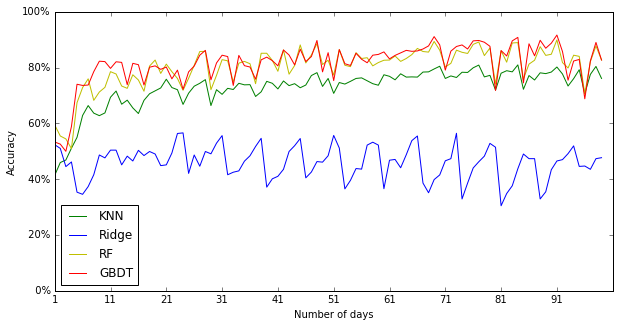

In [19]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_AC, label='KNN', color="g")
ax.plot(rdg_all_AC, label='Ridge', color="b")
ax.plot(rf_all_AC, label='RF', color="y")
ax.plot(gb_all_AC, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of days")
ax.set_xticks(range(0, len(knn_all_AC), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')

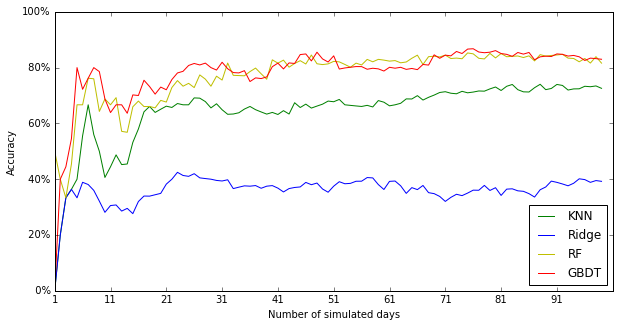

In [20]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_AC_tr, label='KNN', color="g")
ax.plot(rdg_all_AC_tr, label='Ridge', color="b")
ax.plot(rf_all_AC_tr, label='RF', color="y")
ax.plot(gb_all_AC_tr, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of simulated days")
ax.set_xticks(range(0, len(knn_all_AC_tr), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')

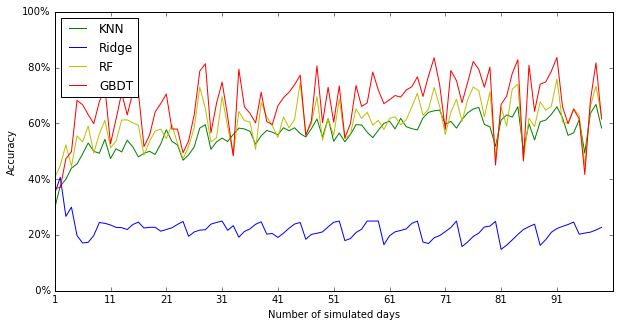

In [21]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_RC, label='KNN', color="g")
ax.plot(rdg_all_RC, label='Ridge', color="b")
ax.plot(rf_all_RC, label='RF', color="y")
ax.plot(gb_all_RC, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of simulated days")
ax.set_xticks(range(0, len(knn_all_RC), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')

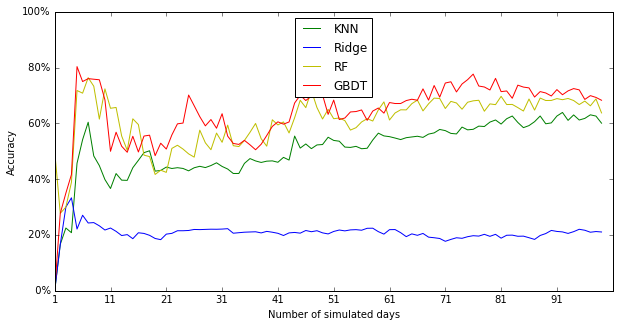

In [22]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_RC_tr, label='KNN', color="g")
ax.plot(rdg_all_RC_tr, label='Ridge', color="b")
ax.plot(rf_all_RC_tr, label='RF', color="y")
ax.plot(gb_all_RC_tr, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of simulated days")
ax.set_xticks(range(0, len(knn_all_RC_tr), 10))
ax.set_xticklabels(range(ini_day, tot_day + 1, 10))
ax.legend(loc='best')

[   0  120  240  360  480  600  720  840  960 1080 1200 1320 1440]


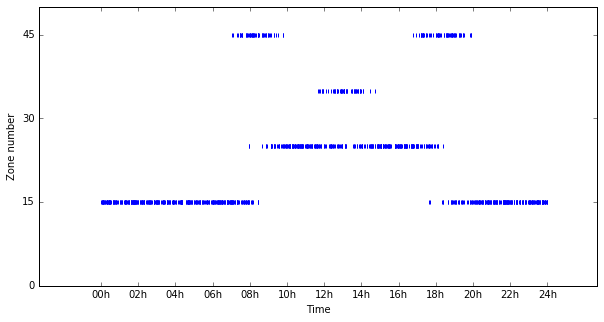

In [23]:
mobiledata_PL = mobiledata_ML.copy()
mobiledata_PL['min_acc'] = mobiledata_PL['hour'] * 60 + mobiledata_PL['minute']
fig1 = plt.figure(figsize=(10,5))
ax = fig1.add_subplot(1, 1, 1)
ax.scatter(mobiledata_PL['min_acc'], mobiledata_PL['tzone'], marker = "|")
ax.set_xticks(range(0, 1441, 1440/12))
ax.set_yticks(range(0, 46, 15))
vals = ax.get_xticks()
print vals
ax.set_xticklabels(['{:02.0f}h'.format(x/60) for x in vals])
ax.set_ylabel("Zone number")
ax.set_xlabel("Time")
# ax2.plot(mobiledata_sel['minute'], mobiledata_sel['tzone_y'])
# ax2.set_xticks(range(0, 1440, 200))
# ax2.set_yticks(range(0, 45, 15))

[   0  120  240  360  480  600  720  840  960 1080 1200 1320 1440]


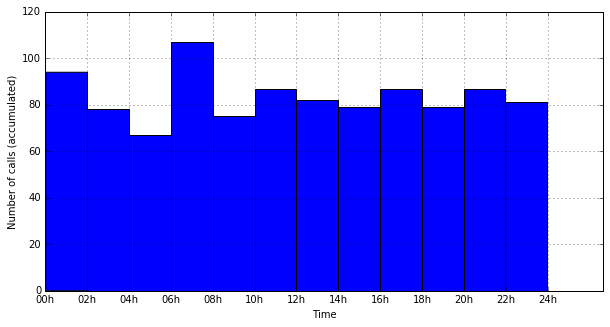

In [24]:
# checking the distribution of mobile phone calls
fig2 = plt.figure(figsize=(10,5))
ax = fig2.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
(mobiledata_PL['min_acc'][pd.notnull(mobiledata_PL['tzone'])]).hist(bins=12)
ax.set_xticks(range(0, 1441, 1440/12))
vals = ax.get_xticks()
print vals
ax.set_xticklabels(['{:02.0f}h'.format(x/60) for x in vals])
ax.set_ylabel("Number of calls (accumulated)")
ax.set_xlabel("Time")
#ax.set_xticks(range(0, 1440, 1440/12))
#plt.hist(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], bins=50)

In [ ]:
mobiledata_PL = mobiledata_ML.copy()
mobiledata_PL['min_acc'] = mobiledata_PL['hour'] * 60 + mobiledata_PL['minute']
print mobiledata_PL.max()
print mobiledata_PL.min()

In [ ]:
import numpy as np
import time
import theano
A = np.random.rand(1000,10000).astype(theano.config.floatX)
B = np.random.rand(10000,1000).astype(theano.config.floatX)
np_start = time.time()
AB = A.dot(B)
np_end = time.time()
X,Y = theano.tensor.matrices('XY')
mf = theano.function([X,Y],X.dot(Y))
t_start = time.time()
tAB = mf(A,B)
t_end = time.time()
print("NP time: %f[s], theano time: %f[s] (times should be close when run on CPU!)" %(
                                           np_end-np_start, t_end-t_start))
print("Result difference: %f" % (np.abs(AB-tAB).max(), ))



In [ ]:
print aa[aa['minute']==789], bb[bb['minute']==789]

In [ ]:
class User(object):
    def __init__(self, name, email):
        self.name = name
        self.email = email
    def commit(self):
        pass

jason = User('jason', 'jason@email.com')
jack = User('jack', 'jack@yahoo.com')

In [ ]:
import os
try:
    user_paths = os.environ['PYTHONPATH'].split(os.pathsep)
except KeyError:
    user_paths = []

In [ ]:
user_paths

In [ ]:
trainX, testX, trainY, testY = traintestsplit_tot[99]
pred_X, pred_y = pr_data_tot[99]

In [ ]:
#trainX.drop('acc_time', axis=1, inplace=True)
trainX.drop('day', axis=1, inplace=True)
#testX.drop('acc_time', axis=1, inplace=True)
testX.drop('day', axis=1, inplace=True)
#pred_X.drop('acc_time', axis=1, inplace=True)
pred_X.drop('day', axis=1, inplace=True)

In [ ]:
## using RF
clf_rf = RandomForestClassifier()#n_estimators=1000, max_depth=100)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average=None)
print accuracy_score(testY, pred_rf)
print recall_score(testY, pred_rf, average='macro')
print recall_score(testY, pred_rf, average='micro')
print confusion_matrix(testY, pred_rf)

pred_rf = clf_rf.predict(pred_X)
print precision_score(pred_y, pred_rf, average=None)
print accuracy_score(pred_y, pred_rf)
print recall_score(pred_y, pred_rf, average='macro')
print recall_score(pred_y, pred_rf, average='micro')
print confusion_matrix(pred_y, pred_rf)


In [ ]:
# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)

pred_knn = clf_knn.predict(pred_X)
print precision_score(pred_y, pred_knn, average=None)
print accuracy_score(pred_y, pred_knn)
print recall_score(pred_y, pred_knn, average='macro')
print recall_score(pred_y, pred_knn, average='micro')
print confusion_matrix(pred_y, pred_knn)

In [ ]:
# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)

pred_knn = clf_knn.predict(pred_X)
print precision_score(pred_y, pred_knn, average=None)
print accuracy_score(pred_y, pred_knn)
print recall_score(pred_y, pred_knn, average='macro')
print recall_score(pred_y, pred_knn, average='micro')
print confusion_matrix(pred_y, pred_knn)


In [ ]:
path = './agentdata.txt'
columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
agentdata = rawimport(path, columnname)
dt_stamp = [datetime.strptime(x,  '%Y-%m-%d %H:%M') for x in agentdata["acc_time"]]
dow = [datetime.isoweekday(x) for x in dt_stamp]
hr = [x.hour for x in dt_stamp]
minu = [x.minute for x in dt_stamp]
agentdata['dow'] = dow
agentdata['hour'] = hr
agentdata['minute'] = minu


path = './mobiletowers.txt'
columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
mobiledata = rawimport(path, columnname)



In [ ]:
dt_stamp = []
for x in agentdata["acc_time"].values:
    dt_stamp.append(datetime.strptime(x, '%Y-%m-%d %H:%M'))
dt_stamp

In [ ]:
#'agentdata['hour'] = hr
agentdata['minute'] = minu

In [ ]:

for x in agentdata["acc_time"].values:
    print parse(x)



In [ ]:
# leave the last n day(s) out for testing purpose

#mobiledata_ML = mobiledata[mobiledata['day'] <= (mobiledata['day'].max() - last_n)]
mobiledata_ML = mobiledata.drop('radius', axis = 1)
mobiledata_ML.drop('tid', axis=1, inplace=True)
mobiledata_ML.drop('txcor', axis=1, inplace=True)
mobiledata_ML.drop('tycor', axis=1, inplace=True)

In [ ]:
# prepare for ML
X = mobiledata_ML.drop('tzone', axis=1)
y = mobiledata_ML['tzone']
trainX, testX, trainY, testY = train_test_split(X, y)

In [ ]:
#k fold cross-validation
from sklearn.cross_validation import KFold

for train_indices, test_indices in KFold(len(X), n_folds=3):
    fold_trainX = X.iloc[train_indices, :]
    fold_testX  = X.iloc[test_indices, :]
    fold_trainY = y[train_indices]
    fold_testY  = y[test_indices]
    clf_knn = KNeighborsClassifier(n_neighbors=2).fit(fold_trainX, fold_trainY)
    pred_knn = clf_knn.predict(fold_testX)
    #print roc_auc_score(testY, pred_knn)
    print precision_score(fold_testY, pred_knn, average='micro')  
    print recall_score(fold_testY, pred_knn, average='micro')
    confusion_matrix(fold_testY, pred_knn)
    #print fold_trainY



In [ ]:


# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)
cross_val_score(clf_knn, X, y, cv=3)

In [ ]:
## using ridge regression
clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
print precision_score(testY, pred_rdg, average='micro')  
print confusion_matrix(testY, pred_rdg)
cross_val_score(clf_rdg, X, y, cv=3)

In [ ]:
## using RF
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=100)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average='micro')  
print confusion_matrix(testY, pred_rf)
cross_val_score(clf_rf, X, y, cv=3)

In [ ]:
## using GBDT
clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
print precision_score(testY, pred_gb, average='micro')  
print confusion_matrix(testY, pred_gb)
cross_val_score(clf_gb, X, y, cv=3)
#test_qualities = []
# for p in clf_gb.staged_predict_proba(testX):
#     test_qualities.append(precision_score(testY, p[:, 1]))
# plt.plot(test_qualities)

In [ ]:
last_n = 1
last_minutes = last_n * (-1440)
pred_X = agentdata[last_minutes:].iloc[:,0:4]
pred_X['tpid'] = 0
pred_y = agentdata[last_minutes:].iloc[:,4]

# pred_knn = trained_clf.clf1.predict(pred_X)
# #print roc_auc_score(testY, pred_knn)
# knn_AC = accuracy_score(pred_y, pred_knn)
# knn_RC = recall_score(pred_y, pred_knn, average='macro')
# knn_CM = confusion_matrix(pred_y, pred_knn)

# ## using ridge regression
# pred_rdg = trained_clf.clf2.predict(pred_X)
# rdg_AC = accuracy_score(pred_y, pred_rdg)
# rdg_RC = recall_score(pred_y, pred_rdg, average='macro')  
# rdg_CM = confusion_matrix(pred_y, pred_rdg)

# ## using RF
# pred_rf = trained_clf.clf3.predict(pred_X)
# rf_AC = accuracy_score(pred_y, pred_rf)
# rf_RC = recall_score(pred_y, pred_rf, average='macro')  
# rf_CM = confusion_matrix(pred_y, pred_rf)

## using GBDT
pred_gb = clf_gb.predict(pred_X)
gb_AC = accuracy_score(pred_y, pred_gb)
gb_RC = recall_score(pred_y, pred_gb, average='macro')  
gb_CM = confusion_matrix(pred_y, pred_gb)

In [ ]:
gb_CM

In [ ]:
## using SVM
## solving multi-classification problem?
clf_svc = SVC()
clf_svc.fit(trainX, trainY)
pred_svc = clf_svc.predict(testX)
print precision_score(testY, pred_svc, average='micro')  
print confusion_matrix(testY, pred_svc)
cross_val_score(clf_svc, X, y, cv=3)


In [ ]:
## prediction
# pre_agent1 = mobiledata[:1]
# pre_agent = pd.concat([pre_agent1]*1440)
# pre_agent['day']=mobiledata['day'].max()+1
# pre_agent['minute']=range(0,1440)
# pre_agent['acc_time']=pre_agent['minute'] + pre_agent['day']*1440
# pre_agent.drop('tzone', axis=1, inplace=True)
# pre_agent.drop('radius', axis=1, inplace=True)
# pre_agent.drop('tid', axis=1, inplace=True)
# pre_agent.drop('txcor', axis=1, inplace=True)
# pre_agent.drop('tycor', axis=1, inplace=True)
pred_X = agentdata[-1440:].iloc[:,0:4]
pred_X['tpid'] = 0
pred_y = agentdata[-1440:].iloc[:,4]


In [ ]:

pred_knn = clf_knn.predict(pred_X)
#print roc_auc_score(testY, pred_knn)
knn_PR = precision_score(pred_y, pred_knn, average='micro')
knn_CM = confusion_matrix(pred_y, pred_knn)

## using ridge regression
pred_rdg = clf_rdg.predict(pred_X)
rdg_PR = precision_score(pred_y, pred_rdg, average='micro')  
rdg_CM = confusion_matrix(pred_y, pred_rdg)

## using RF
pred_rf = clf_rf.predict(pred_X)
rf_PR = precision_score(pred_y, pred_rf, average='micro')  
rf_CM = confusion_matrix(pred_y, pred_rf)

## using GBDT
pred_gb = clf_gb.predict(pred_X)
gb_PR = precision_score(pred_y, pred_gb, average='micro')  
gb_CM = confusion_matrix(pred_y, pred_gb)

print knn_PR, rdg_PR, rf_PR, gb_PR


In [ ]:
pred_gb






In [ ]:
pre_agent

In [ ]:
# prepare for ML
X = mobiledata_fs_filled.drop('zone', axis=1)
y = mobiledata_fs_filled['zone']
trainX, testX, trainY, testY = train_test_split(X, y)

## using KNN
# weights might need to be changed - more weights towards the recent data?
# metrics? canberra, minkowski
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
knn_PR = precision_score(testY, pred_knn, average='micro')
knn_CM = confusion_matrix(testY, pred_knn)

## using ridge regression
clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
rdg_PR = precision_score(testY, pred_rdg, average='micro')  
rdg_CM = confusion_matrix(testY, pred_rdg)

## using RF
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
rf_PR = precision_score(testY, pred_rf, average='micro')  
rf_CM = confusion_matrix(testY, pred_rf)

## using GBDT
clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
gb_PR = precision_score(testY, pred_gb, average='micro')  
gb_CM = confusion_matrix(testY, pred_gb)

In [ ]:
#class ReturnValue(object):
#    def __init__(self, y0, y1):
#        self.y0 = y0
#        self.y1 = y1

def data_input():
    path = './agentdata.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
    agentdata = rawimport(path, columnname)
    
    path = './mobiletowers.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
    mobiledata = rawimport(path, columnname)
    
    # extend data to full (missing data shown as NaN)
    mobiledata = mobiledata.drop(labels = ["tid"], axis=1)

    mobiledata_fs = pd.merge(agentdata, mobiledata, how = 'left', on = ["acc_time", 'day', 'minute', "pid"])
    #mobiledata_fs = pd.merge(agentdata_ri, mobiledata_ri, how = 'left', left_index = True, right_index = True)
    #print mobiledata_fs.count()
    #mobiledata_fs
# fill the missing data using NN (k=1)
# the reason why "day" and "minute" need to be removed before imputation is that the imputation is done based on features.
# in other words, the day and minute will have impacts on the imputed results
# to maintain a continuity of a user between days it is necessary to remove "day" and "minute" before imputation and add them back later
# also no need to imputate tower id
    mobiledata_fs_test = mobiledata_fs.drop(labels = ["day"], axis=1)
    mobiledata_fs_test = mobiledata_fs_test.drop(labels = ["minute"], axis=1)
    mobiledata_fs_test = mobiledata_fs_test.drop(labels = ["tid"], axis=1)
    mobiledata_fs_filled = KNN(k=1).complete(mobiledata_fs_test)
    mobiledata_fs_filled = pd.DataFrame(mobiledata_fs_filled, columns = ["acc_time", "pid", "zone", 
                                                                     "status", "xcor", "ycor", "tpid", "tzone", 
                                                                     "radius", "txcor", "tycor"])
# add the day and minute information back
    mobiledata_daymin = mobiledata_fs.ix[:,[0, 1, 2, 3, 8]]
    mobiledata_fs_filled = pd.merge(mobiledata_daymin, mobiledata_fs_filled, how = 'left', on = ["acc_time", "pid"])
    mobiledata_cp = pd.merge(mobiledata_fs, mobiledata_fs_filled, how = 'left', on = ["acc_time", 'day', 'minute', "pid"])
    mobiledata_fs_filled.fillna(-1, inplace=True)
    
    return (mobiledata_fs, mobiledata_fs_filled, mobiledata_cp)

In [ ]:
#run_NL()

mobiledata_fs, mobiledata_fs_filled, mobiledata_cp = data_input()
#miss_imput()

In [ ]:
print mobiledata_fs_filled.count()

In [ ]:
mobiledata_fs_filled.zone.max()


In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
mobiledata_sel = mobiledata_cp[mobiledata_cp['day'] == 0]
ax1.scatter(mobiledata_sel['minute'], mobiledata_sel['tzone_x'])
ax1.set_xticks(range(0, 1440, 200))
ax1.set_yticks(range(0, 45, 15))
ax2.plot(mobiledata_sel['minute'], mobiledata_sel['tzone_y'])
ax2.set_xticks(range(0, 1440, 200))
ax2.set_yticks(range(0, 45, 15))

In [ ]:
# checking the distribution of mobile phone calls
fig2 = plt.figure(figsize=(10,5))
ax = fig2.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])]).hist(bins=12)
#plt.hist(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], bins=50)

In [ ]:
# ML
def NL_ML(mobiledata_fs_filled):
    # prepare for ML
    X = mobiledata_fs_filled.drop('zone', axis=1)
    y = mobiledata_fs_filled['zone']
    trainX, testX, trainY, testY = train_test_split(X, y)
    
    ## using KNN
    # weights might need to be changed - more weights towards the recent data?
    # metrics? canberra, minkowski
    clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
    pred_knn = clf_knn.predict(testX)
    #print roc_auc_score(testY, pred_knn)
    knn_PR = precision_score(testY, pred_knn, average='micro')
    knn_CM = confusion_matrix(testY, pred_knn)
    
    ## using ridge regression
    clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
    pred_rdg = clf_rdg.predict(testX)
    rdg_PR = precision_score(testY, pred_rdg, average='micro')  
    rdg_CM = confusion_matrix(testY, pred_rdg)
    
    ## using RF
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
    clf_rf.fit(trainX, trainY)
    pred_rf = clf_rf.predict(testX)
    rf_PR = precision_score(testY, pred_rf, average='micro')  
    rf_CM = confusion_matrix(testY, pred_rf)
    
    ## using GBDT
    clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    clf_gb.fit(trainX, trainY)
    pred_gb = clf_gb.predict(testX)
    gb_PR = precision_score(testY, pred_gb, average='micro')  
    gb_CM = confusion_matrix(testY, pred_gb)
    
    return (knn_PR, knn_CM, rdg_PR, rdg_CM, rf_PR, rf_CM, gb_PR, gb_CM)

In [ ]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_PR, label='NN', color="g")
ax.plot(rdg_all_PR, label='Ridge', color="b")
ax.plot(rf_all_PR, label='RF', color="y")
ax.plot(gb_all_PR, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

In [ ]:
knn_all_PR

In [ ]:
t = NL_ML(comdata_fs_filled)

In [ ]:
print gb_all_PR


In [ ]:
print t


In [ ]:
# prepare for ML

X = mobiledata_fs_filled.drop('zone', axis=1)
y = mobiledata_fs_filled['zone']

trainX, testX, trainY, testY = train_test_split(X, y)


In [ ]:
## using KNN
# weights might need to be changed - more weights towards the recent data?
# metrics? canberra, minkowski


clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average='micro')  
print recall_score(testY, pred_knn, average='micro')
confusion_matrix(testY, pred_knn)

In [ ]:
pred_knn.shape

In [ ]:
testX, pred_knn

In [ ]:
## using Ridge

clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
print precision_score(testY, pred_rdg, average='micro')  
print recall_score(testY, pred_rdg, average='micro')
confusion_matrix(testY, pred_rdg)

In [ ]:
## using Lasso

clf_las = Lasso(alpha=1).fit(trainX,trainY)
pred_las = clf_las.predict(testX)
print precision_score(testY, pred_las, average='micro')  
print recall_score(testY, pred_las, average='micro')
confusion_matrix(testY, pred_las)

In [ ]:
## using RF

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average='micro')  
print recall_score(testY, pred_rf, average='micro')
confusion_matrix(testY, pred_rf)

In [ ]:
## using GBDT

clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
print precision_score(testY, pred_gb, average='micro')  
print recall_score(testY, pred_gb, average='micro')
confusion_matrix(testY, pred_gb)

In [ ]:
# neural network
def fit_predict_NN(trainX, trainY, testX, activate_functions, hidden_layers):
    X_ = theano.shared(trainX, name='X')
    y_ = theano.shared(trainY, name='y')
    param = T.vector()
    dim = X.shape[1]
    
    def activation(data_, parameter):
        n_previous = 0
        dim_previous = dim
        h = data_
        for n_hidden, func in zip(hidden_layers, activate_functions):
            N = dim_previous * n_hidden
            W_ = parameter[n_previous:n_previous + N].reshape((dim_previous, n_hidden))
            h = func(h.dot(W_))
            dim_previous = n_hidden
            n_previous += N

        # output     
        v_ = parameter[n_previous:]
        output = h.dot(v_)
        n_previous = n_previous + dim_previous
        
        return T.nnet.sigmoid(output), n_previous

    p_sig = activation(X_, param)[0]
    p_bck = 1 - p_sig
    llh_ = y_.dot(T.log(p_sig)) + (1 - y_).dot(T.log(p_bck))
    loss = -llh_
    
    # optimize
    loss_function = theano.function([param], loss)
    loss_grad = theano.function([param], theano.grad(loss, param))
    result = minimize(loss_function, jac=loss_grad, x0=numpy.random.normal(size=activation(X_, param)[1]))
    optimal_params = result['x']
    
    # predict data
    data = T.matrix()
    compiled_activation = theano.function([data, param], activation(data, param)[0])
    
    return compiled_activation(testX, optimal_params)


In [ ]:
## define activation function
#sigmoid (which we used, T.nnet.sigmoid)
#leaky ReLU (defined below)
#softplus (T.nnet.softplus)

def LeakyReLU(x):
    return T.switch(x > 0, x, 0.5 * x)


In [ ]:
pred = fit_predict_NN(trainX, trainY, testX, [T.nnet.sigmoid] * 3, [20, 10, 5])
print precision_score(testY, pred, average='micro')  
print recall_score(testY, pred, average='micro')

In [ ]:
import numpy as np
import time
import theano
A = np.random.rand(1000,10000).astype(theano.config.floatX)
B = np.random.rand(10000,1000).astype(theano.config.floatX)
np_start = time.time()
AB = A.dot(B)
np_end = time.time()
X,Y = theano.tensor.matrices('XY')
mf = theano.function([X,Y],X.dot(Y))
t_start = time.time()
tAB = mf(A,B)
t_end = time.time()
print("NP time: %f[s], theano time: %f[s] (times should be close when run on CPU!)" %(
                                           np_end-np_start, t_end-t_start))
print("Result difference: %f" % (np.abs(AB-tAB).max(), ))